In [1]:
import sys
import torch.optim as optim
from torch import nn
import torch
from torchtext.legacy import data
from torchtext.legacy.vocab import Vectors
# from torchtext.vocab import Vectors
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import tqdm
import re
from bs4 import BeautifulSoup
from collections import defaultdict

### Datasets can be downloaded from:
- https://www.kaggle.com/vinay45/jigsaw-toxic-comment-classification-challenge
- https://www.kaggle.com/c/jigsaw-toxic-severity-rating

### Bi-LSTM code adopted from: https://github.com/AnubhavGupta3377/Text-Classification-Models-Pytorch

In [2]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip()
 # remove spaces at the beginning and at the end of string

    return text

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


  0%|          | 0/35470 [00:00<?, ?it/s]

  0%|          | 0/60216 [00:00<?, ?it/s]

  0%|          | 0/7537 [00:00<?, ?it/s]

    label                                               text
0       2  A little clique controls the Technocracy artic...
1       3  unblock FUCKING UNBLOCK ME OR ILL FUCKING BAN ...
2       1  293 500 house According to a Wall Street Journ...
3       3  IF YOU REVERT MY FUCKIN EDITS METROS I WILL KI...
4       2  E kala mai my apologies Aloha MZMcBride I just...
5       1  third knight can i please know how you can pro...
6       4                      GO FUCK YOURSELF ALLAHU AKBAR
7       2                      Here s your fucking reference
8       1  Yeah I m working to come up with that somethin...
9       2  Ya deleted my thread I m really gonna sue ya n...
10      1  Oh that can surely be done but this discussion...
11      2  So you are the miserable envious shmack Ok it ...
12      1  rm speedy not quite sure it s that badly spam ...
13      2  I suppose you people are content to allow raci...
14      1  I can provide proof of detailed involvement wi...
15      1  I also find y

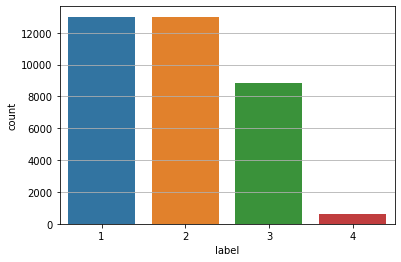

In [3]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
df_test_ = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
df_test_lab = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
df_test = pd.merge(df_test_, df_test_lab, on="id")
df_mrgd = pd.concat([df_train, df_test], axis = 0)
df_mrgd.describe()
###########
df_mrgd = df_mrgd[df_mrgd["toxic"]>=0]
df_mrgd.head()
df_mrgd["severe_toxic"] = df_mrgd["severe_toxic"]
df_mrgd["threat"] = df_mrgd["threat"]
df_mrgd["tx_sum"] = df_mrgd["toxic"]+ 2*df_mrgd["severe_toxic"] + df_mrgd["obscene"] + 2*df_mrgd["threat"] + df_mrgd["insult"] + df_mrgd["identity_hate"]
df_mrgd["tx_sum_norm"] = df_mrgd["tx_sum"]/8
# df_mrgd[df_mrgd["tx_sum_norm"]>0]["tx_sum_norm"].hist(bins=20)

def define_tx_class(x):
    if x==0:
        return 0
    if x>0 and x<=0.33:
        return 1
    if x>0.33 and x<=0.66:
        return 2
    if x>0.66:
        return 3

df_mrgd["tx_class"] = df_mrgd.apply(lambda x: define_tx_class(x["tx_sum_norm"]), axis=1)
# df_mrgd[df_mrgd["tx_class"]>0]["tx_class"].hist(bins=20)
# df_mrgd[df_mrgd["tx_class"]==3].head(10)
df_mrgd["text"] = df_mrgd["comment_text"]
df_mrgd["label"] = df_mrgd["tx_class"]
df_mrgd = df_mrgd[["label", "text"]]
############

# ############
min_class_count = len(df_mrgd[df_mrgd["label"]==1]) #number of not toxic samples equal to number of least toxic class samples
df_0_undersampled = df_mrgd.loc[df_mrgd["label"]==0,].sample(n=min_class_count,random_state=1234)
df_mrgd = pd.concat([df_0_undersampled,df_mrgd.loc[df_mrgd["label"]!=0,]])
df_mrgd["label"].hist()

# #####
df_mrgd["label"] = df_mrgd["label"]+1
df_mrgd.describe()
sns.countplot("label", data = df_mrgd)
# df_mrgd.to_csv('merged_data.csv', header = False, index = False)


# ########
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv')[['less_toxic', 'more_toxic']]
tx, ntx = list(test_df["more_toxic"]), list(test_df["less_toxic"])
data_ = [[2, t] for t in tx]+[[1, t] for t in ntx]
test_df = pd.DataFrame(data_, columns = ["label", "text"])

###########
score_df = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv')

#############
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

df_mrgd['text'] = df_mrgd['text'].progress_apply(text_cleaning)
test_df['text'] = test_df['text'].progress_apply(text_cleaning)
score_df['text'] = score_df['text'].progress_apply(text_cleaning)
score_df_= score_df.copy()
score_df_ = score_df_[['text']]
score_df_['label'] = 1
score_df_ = score_df_[["label", "text"]]
###########

df_mrgd = df_mrgd.sample(frac=1).reset_index(drop=True)
print(df_mrgd.head(30))
print(test_df.head(30))

In [4]:
class Dataset(object):
    def __init__(self, config):
        self.config = config
        self.train_iterator = None
        self.test_iterator = None
        self.val_iterator = None
        self.vocab = []
        self.word_embeddings = {}

    def get_pandas_df(self, filename):
        
        full_df = pd.read_csv(filename)
        # must have "text" and "label" columns
        return full_df
    
    def load_data(self, w2v_file, train_df, test_df, score_df, val_file=None):
        '''
        Loads the data from files
        Sets up iterators for training, validation and test data
        Also create vocabulary and word embeddings based on the data
        
        Inputs:
            w2v_file (String): absolute path to file containing word embeddings (GloVe/Word2Vec)
            train_file (String): absolute path to training file
        '''

        NLP = spacy.load('en_core_web_sm')
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]
        
        # Creating Field for data
        TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, fix_length=self.config.max_sen_len)
        LABEL = data.Field(sequential=False, use_vocab=False)
        datafields = [("label",LABEL), ("text",TEXT)]
        

        train_examples = [data.Example.fromlist(i, datafields) for i in train_df.values.tolist()]
        train_data = data.Dataset(train_examples, datafields)

        test_examples = [data.Example.fromlist(i, datafields) for i in test_df.values.tolist()]
        test_data = data.Dataset(test_examples, datafields)
        
        score_examples = [data.Example.fromlist(i, datafields) for i in score_df.values.tolist()]
        score_data = data.Dataset(score_examples, datafields)
        
        train_data, val_data = train_data.split(split_ratio=0.9, stratified=True, strata_field="label", random_state=None)
        
        TEXT.build_vocab(train_data, vectors=Vectors(w2v_file))
        self.word_embeddings = TEXT.vocab.vectors
        self.vocab = TEXT.vocab
        
        self.train_iterator = data.BucketIterator(
            (train_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=True)

        
        self.val_iterator = data.BucketIterator(
            (val_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        
        self.test_iterator = data.BucketIterator(
            (test_data),
            batch_size=1,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        
        self.score_iterator = data.BucketIterator(
            (score_data),
            batch_size=1,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        
        
        print ("Loaded {} training examples".format(len(train_data)))
#         print ("Loaded {} test examples".format(len(test_data)))
        print ("Loaded {} validation examples".format(len(val_data)))
    
def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.text
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
        all_preds.extend(predicted.numpy())
        all_y.extend(batch.label.numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    return score

In [5]:
class TextRNN(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(TextRNN, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        self.lstm = nn.LSTM(input_size = self.config.embed_size,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            dropout = self.config.dropout_keep,
                            bidirectional = self.config.bidirectional)
        
        self.dropout = nn.Dropout(self.config.dropout_keep)
        
        # Fully-Connected Layer
        self.fc = nn.Linear(
            self.config.hidden_size * self.config.hidden_layers * (1+self.config.bidirectional),
            self.config.output_size
        )
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()
        self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        # x.shape = (max_sen_len, batch_size)
        embedded_sent = self.embeddings(x)
        # embedded_sent.shape = (max_sen_len=20, batch_size=64,embed_size=300)

        lstm_out, (h_n,c_n) = self.lstm(embedded_sent)
        final_feature_map = self.dropout(h_n) # shape=(num_layers * num_directions, 64, hidden_size)
        
        # Convert input to (64, hidden_size * hidden_layers * num_directions) for linear layer
        final_feature_map = torch.cat([final_feature_map[i,:,:] for i in range(final_feature_map.shape[0])], dim=1)
        final_out = self.fc(final_feature_map)
        return self.logsoftmax(final_out)
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        train_accuracies = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for i, batch in enumerate(train_iterator):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = batch.text.cuda()
                y = (batch.label - 1).type(torch.cuda.LongTensor)
            else:
                x = batch.text
                y = (batch.label - 1).type(torch.LongTensor)
            y_pred = self.__call__(x)
            loss = self.loss_op(y_pred, y)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
    
            if i % 100 == 0:
                print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
#                 train_accuracy = evaluate_model(self, train_iterator)
#                 train_accuracies.append(train_accuracy)
                
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                val_accuracies.append(val_accuracy)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies

100%|█████████▉| 2196017/2196018 [05:01<00:00, 7272.98it/s]


Loaded 31923 training examples
Loaded 3547 validation examples
Data Loading Complete
Epoch: 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iter: 1
	Average training loss: 1.37861
	Val Accuracy: 0.3392
Iter: 101
	Average training loss: 1.12131
	Val Accuracy: 0.4962
Iter: 201
	Average training loss: 0.99012
	Val Accuracy: 0.6002
Iter: 301
	Average training loss: 0.87718
	Val Accuracy: 0.6188
Iter: 401
	Average training loss: 0.81387
	Val Accuracy: 0.6569
Epoch: 1
Iter: 1
	Average training loss: 0.60402
	Val Accuracy: 0.7006
Iter: 101
	Average training loss: 0.76248
	Val Accuracy: 0.7023
Iter: 201
	Average training loss: 0.73437
	Val Accuracy: 0.6735
Iter: 301
	Average training loss: 0.72889
	Val Accuracy: 0.7133
Iter: 401
	Average training loss: 0.71417
	Val Accuracy: 0.6992
Epoch: 2
Iter: 1
	Average training loss: 0.58751
	Val Accuracy: 0.7076
Iter: 101
	Average training loss: 0.68252
	Val Accuracy: 0.7215
Iter: 201
	Average training loss: 0.70079
	Val Accuracy: 0.7186
Iter: 301
	Average training loss: 0.68333
	Val Accuracy: 0.7248
Iter: 401
	Average training loss: 0.67631
	Val Accuracy: 0.7169
Epoch: 3
Iter: 1
	Average tr

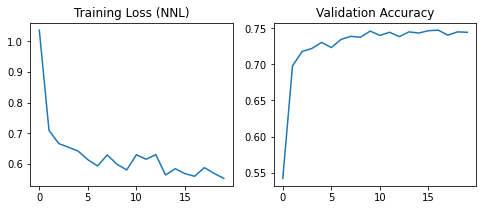

In [6]:
def evaluate_testdata(model, iterator):
    test_tx_classes = []
    test_tx_scores = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.text
        y_pred = model(x)
#         print(x)
#         print(y_pred.cpu().data)
        
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
#         print("###predicted class: {} #####".format(predicted.item()))
        test_tx_classes.append(predicted.item())
        test_tx_scores.append(y_pred[0,predicted.item()-1].item())

    return test_tx_classes, test_tx_scores

def evaluate_scoredata(model, iterator):
    score_tx_scores = []
    score_df__ = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv')
    comment_scores = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.text
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
        score_tx_scores.append(y_pred[0,predicted.item()-1].item()+predicted.item())
        
        comment_scores.append(
            {
            'comment_id': score_df__.iloc[idx,0],
            'score': y_pred[0,predicted.item()-1].item()+predicted.item()
            })
#         if idx<10:
#             print(score_df__.loc[idx])
#             print(y_pred.cpu().data)
#             print("predicted class: {}".format(predicted.item()))

    score_df = pd.DataFrame(comment_scores)
    score_df.to_csv("submission.csv", index = False)
    return 0



class Config(object):
    embed_size = 300
    hidden_layers = 4
    hidden_size = 32
    bidirectional = True
    output_size = 4
    max_epochs = 20
    lr = 0.25
    batch_size = 64
    max_sen_len = 30 # Sequence length for RNN
    dropout_keep = 0.8

w2v_file = '/kaggle/input/glove840b300dtxt/glove.840B.300d.txt'
config = Config()
dataset = Dataset(config)
dataset.load_data(w2v_file, df_mrgd, test_df, score_df_)

print("Data Loading Complete")

model = TextRNN(config, len(dataset.vocab), dataset.word_embeddings)
if torch.cuda.is_available():
    model.cuda()
model.train()
optimizer = optim.SGD(model.parameters(), lr=config.lr)
NLLLoss = nn.NLLLoss()
model.add_optimizer(optimizer)
model.add_loss_op(NLLLoss)

train_losses = []
train_accuracies = []
val_accuracies = []

for i in range(config.max_epochs):
    print ("Epoch: {}".format(i))
    train_loss, val_accuracy = model.run_epoch(dataset.train_iterator, dataset.val_iterator, i)
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)

train_acc = evaluate_model(model, dataset.train_iterator)
print("Train accuracy: {}".format(train_acc))
val_acc = evaluate_model(model, dataset.val_iterator)
print("Valid accuracy: {}".format(val_acc))

import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize = (8,3))
train_losses_mean = [np.mean(train_loss) for train_loss in train_losses]
vall_acc_mean = [np.mean(val_acc) for val_acc in val_accuracies]
ax[0].plot(train_losses_mean)
ax[0].set_title("Training Loss (NNL)")
ax[1].plot(vall_acc_mean)
ax[1].set_title("Validation Accuracy")

tx_clss, tx_scrs = evaluate_testdata(model, dataset.test_iterator)

n_test = int(len(tx_scrs)*0.5)
more_tx_scrs, less_tx_scrs = tx_scrs[:n_test], tx_scrs[n_test:]
more_tx_clss, less_tx_clss = tx_clss[:n_test], tx_clss[n_test:]



# evaluate_scoredata(model, dataset.score_iterator)

In [7]:
match = [1 if ((more_tx_clss[i]>less_tx_clss[i]) or ((more_tx_clss[i]==less_tx_clss[i]) and (more_tx_scrs[i]>less_tx_scrs[i]))) else 0 for i in range(n_test)]
accuracy = sum(match)/len(match)
print("Accuracy on validation data: {}".format(accuracy))

Accuracy on validation data: 0.6411917098445595


In [8]:
evaluate_scoredata(model, dataset.score_iterator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0

## Results as on Kaggle:
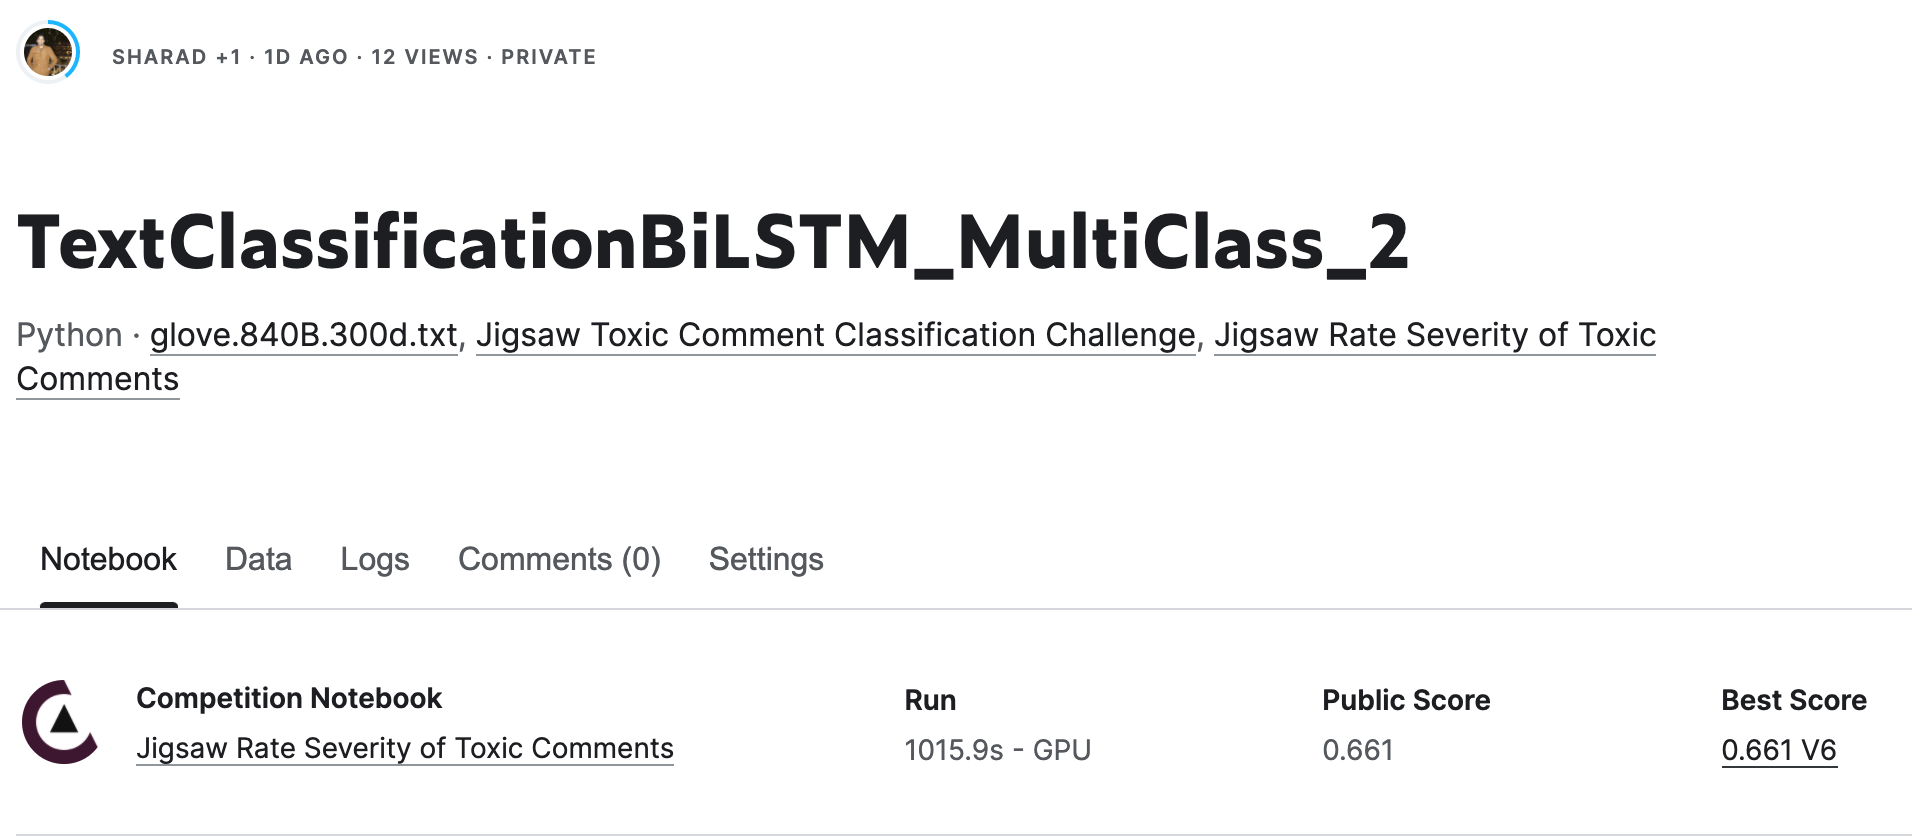